In [21]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import style

YEARS = list(range(2003, 2019))
FEATURES = ['df', 'tf', 'author_num', 'ref_num', 'fund_num', 'kw_num', 'kp_num', 'cat_num', 'es']

### 载入数据

In [3]:
# Load the numpy array with shape (2643, 17, 10)
# (term_num, time_steps, feature_num)
# features: 'df', 'tf', 'author_num', 'ref_num', 'fund_num', 'kw_num', 'kp_num', 'cat_num'

gene_arr = pickle.load(open('output/gene_editing/es_with_decay.array', mode='rb'))
trans_arr = pickle.load(open('output/transplant/es_with_decay.array', mode='rb'))

gene_terms = pickle.load(open('output/gene_editing/ordered_list.list', mode='rb'))
trans_terms = pickle.load(open('output/transplant/ordered_list.list', mode='rb'))

print('Shape of the gene_editing data:', gene_arr.shape)
print('Shape of the transplant data:', trans_arr.shape)

Shape of the gene_editing data: (2643, 17, 10)
Shape of the transplant data: (5141, 17, 10)


### 2019年的数据为wos错误导出的，排除

In [4]:
gene_arr = gene_arr[:, :-1, :]
trans_arr = trans_arr[:, :-1, :]

print('Shape of the gene_editing data:', gene_arr.shape)
print('Shape of the transplant data:', trans_arr.shape)

Shape of the gene_editing data: (2643, 16, 10)
Shape of the transplant data: (5141, 16, 10)


### 整体Emerging Score在16年间的分布情况

可以看到随着时间增长，Emerging Score整体是在上升的

并且它的分布很不均衡，离群点很多

In [97]:
gene_es = gene_arr[:, :, -2]
trans_es = trans_arr[:, :, -2]

def es_annual_boxplot(es, title):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.boxplot(es)
    ax.set_xticklabels(YEARS)
    ax.set_xlabel('Year')
    ax.set_ylabel('Emerging Score')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def es_annual_errorplot(es, title):
    median = np.median(es, axis=0)
    upper_75 = np.percentile(es, [75], axis=0).reshape(-1) - median
    lower_25 = median - np.percentile(es, [25], axis=0).reshape(-1)
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.errorbar(range(len(median)), median, yerr=[lower_25, upper_75],
                fmt='o', capsize=4, elinewidth=1, ecolor='black', markersize=8)
    ax.set_xticks(np.arange(len(YEARS)))
    ax.set_xticklabels(YEARS)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Popularity Score', fontsize=18)
#     ax.set_title(title)
    ax.grid(axis='y', ls='--', lw=1)
    plt.tight_layout()
    plt.savefig(title + '.jpg')
    plt.show()

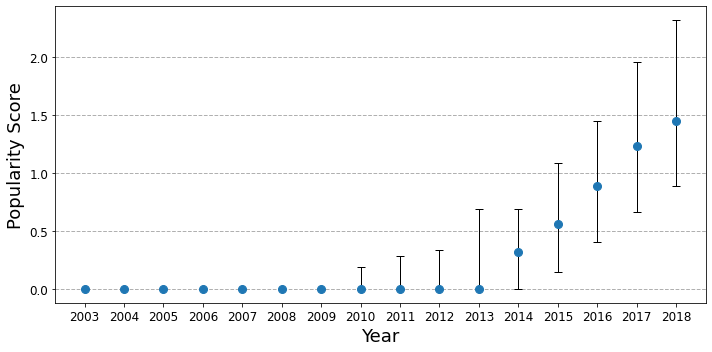

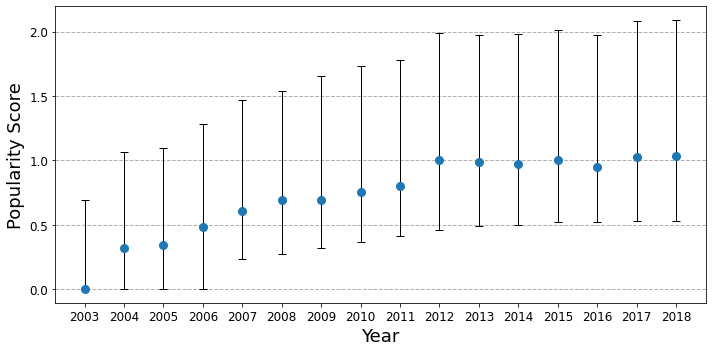

In [98]:
# es_annual_boxplot(gene_es, 'Gene editing')
# es_annual_boxplot(trans_es, 'Transplant')

es_annual_errorplot(gene_es, 'Gene editing')
es_annual_errorplot(trans_es, 'Transplant')

### 随机抽取术语观察其在16年间的变化

波动较大，术语之间、同一个术语前后的规律都不太一样

利用线性回归线可以大致估计其趋势

头11年gene editing的很多都是直线

In [103]:
def random_show_terms():
    num = 3
    gene_rids = list(np.random.choice(range(len(gene_arr)), size=num, replace=False))
    trans_rids = list(np.random.choice(range(len(trans_arr)), size=num, replace=False))

    rids = gene_rids + trans_rids

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,12))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    i = 0
    for i in range(len(axes)):
        x = range(len(YEARS))
        if i < len(axes) / 2:
            axes[i].plot(x[:11], gene_es[rids[i]][:11])
            a, b = np.polyfit(range(len(YEARS)), gene_es[rids[i]], 1)
#             axes[i].plot(x, a*x+b, label='a={:.2f}'.format(a))
            axes[i].set_title('Gene editing:' + str(gene_terms[rids[i]]))
        else:
            axes[i].plot(x[:11], trans_es[rids[i]][:11])
            a, b = np.polyfit(range(len(YEARS)), trans_es[rids[i]], 1)
#             axes[i].plot(x, a*x+b, label='a={:.2f}'.format(a))
            axes[i].set_title('Transplant:' + str(trans_terms[rids[i]]))
#         axes[i].set_xticks(np.arange(len(YEARS)))
        axes[i].set_xticklabels(YEARS)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Emerging Score')
#         axes[i].legend()

    plt.tight_layout()
    plt.show()

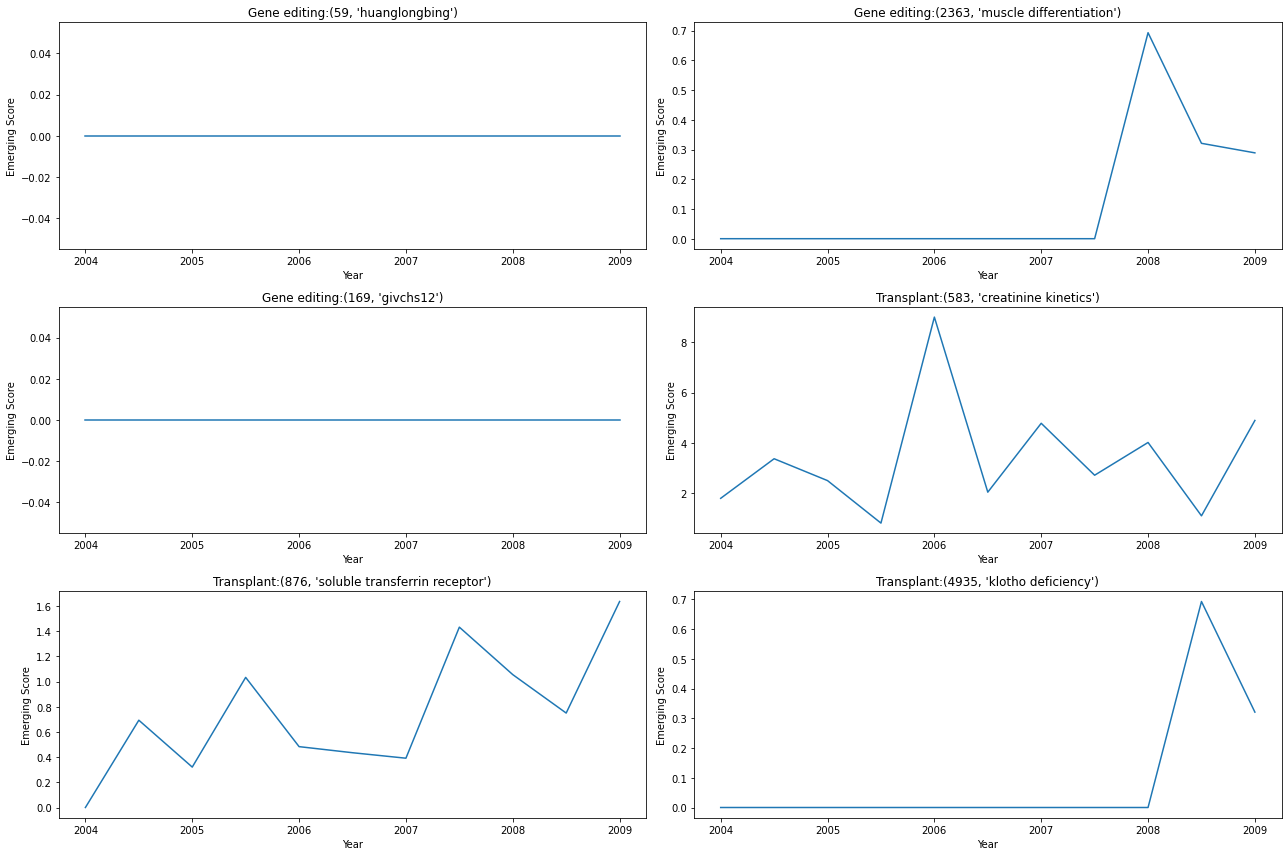

In [116]:
random_show_terms()

### 每个术语Emerging Score总量

如果要按总量来分的话，按照这样的分法可能比较合适（从高到低）：
- 离群点（大于Q3+1.5IQR）
- 较高（Q3+1.5IQR 到 Q3之间）
- 中间（Q3 到 Q1之间）
- 较低（Q1 到 最小值之间）

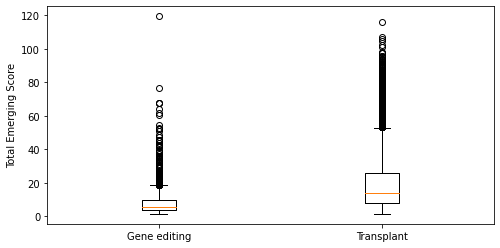

In [9]:
gene_total_es = np.sum(gene_es, axis=1)
trans_total_es = np.sum(trans_es, axis=1)

def compare_total_es(es1, es2):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.boxplot((es1, es2))
    ax.set_xticklabels(['Gene editing', 'Transplant'])
    ax.set_ylabel('Total Emerging Score')
    plt.show()

compare_total_es(gene_total_es, trans_total_es)

### 各词汇各项指标的分布情况

In [24]:
total_gene = np.sum(gene_arr, axis=1)
total_trans = np.sum(trans_arr, axis=1)

d = {}
for i, feat in enumerate(FEATURES):
    d[feat] = total_gene[:, i]
    
df = pd.DataFrame(d)
df.describe()

,df,tf,author_num,ref_num,fund_num,kw_num,kp_num,cat_num,es
count,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000
mean,11.953840,20.589482,80.199395,564.848278,30.414302,33.611426,80.974272,10.909951,8.046886
std,133.344531,231.597840,800.508916,3954.158050,288.147366,245.117846,395.375978,16.937170,7.553031
min,2.000000,3.000000,4.000000,32.000000,0.000000,0.000000,8.000000,1.000000,1.386294
25%,3.000000,7.000000,23.000000,175.000000,8.000000,10.000000,30.000000,5.000000,3.753431
50%,5.000000,10.000000,37.000000,272.000000,14.000000,18.000000,44.000000,7.000000,5.723676
75%,9.000000,16.000000,66.000000,490.500000,26.000000,30.000000,77.000000,12.000000,9.686014
max,6731.000000,11763.000000,40331.000000,196494.000000,14487.000000,12201.000000,19216.000000,534.000000,119.387941


In [25]:
d = {}
for i, feat in enumerate(FEATURES):
    d[feat] = total_trans[:, i]
    
df = pd.DataFrame(d)
df.describe()

,df,tf,author_num,ref_num,fund_num,kw_num,kp_num,cat_num,es
count,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000,5141.000000
mean,29.241587,58.062245,220.175452,703.136744,15.999027,69.679051,156.898658,27.382027,20.357286
std,107.088979,212.298768,835.448809,2483.514230,60.613467,221.217140,458.017656,26.488129,17.662659
min,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.386294
25%,5.000000,11.000000,34.000000,113.000000,2.000000,12.000000,30.000000,11.000000,8.073851
50%,9.000000,19.000000,64.000000,218.000000,5.000000,24.000000,54.000000,18.000000,13.770191
75%,20.000000,38.000000,144.000000,496.000000,12.000000,52.000000,121.000000,34.000000,26.017059
max,2916.000000,5949.000000,22064.000000,60955.000000,1822.000000,5537.000000,10823.000000,224.000000,115.699645
